## Observations from PPO  

**Species:** Syringa
<br>
**Phenophase:** PPO:0002032(flower presence) 
<br>
https://raw.githubusercontent.com/PlantPhenoOntology/ppo/master/documentation/ppo.pdf

In [1]:
!rm -r ~/ppo_download/
!rm -r /tmp/data/PPO/

In [9]:
import springtime
from springtime.datasets.ppo import RPPO

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import folium

In [3]:
#dataset = RPPO(genus="Quercus Pinus", termID="obo:PPO_0002313", limit=10, years=[2019, 2020])
dataset = RPPO(genus="Syringa", termID="obo:PPO_0002032", limit=99000, years=[1950, 2020])
dataset

RPPO(dataset='rppo', genus='Syringa', termID='obo:PPO_0002032', years=(1950, 2020), area=None, limit=99000, timeLimit=60)

In [4]:
dataset.download()


R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(rppo)
>         response <- ppo_data(genus = c("Syringa"), termID='obo:PPO_0002032',
+             
+             fromYear=1950, toYear=2020,
+             limit=99000, timeLimit = 60)


sending request for data ...
https://biscicol.org/api/v3/download/_search?q=+genus:Syringa++AND+++termID:"obo:PPO_0002032"++AND+++year:>=1950++AND+++year:<=2020++AND+++source:USA-NPN&limit=99000


>         saveRDS(response, file="/tmp/data/PPO/Syringa.obo:PPO_0002032.1950-2020.na.rds")
>         
> 


In [5]:
#ls ~/ppo_download/

In [6]:
df = dataset.load()
df.head()

,dayOfYear,year,genus,specificEpithet,eventRemarks,termID,source,eventId,geometry
1,199,2017,Syringa,chinensis,End of flowering (lilac/honeysuckle),"obo:PPO_0002323,obo:PPO_0002324,obo:PPO_000200...",USA-NPN,urn:phenologicalObservingProcess/11412662,POINT (-87.71904 41.91366)
2,131,2019,Syringa,chinensis,End of flowering (lilac/honeysuckle),"obo:PPO_0002323,obo:PPO_0002324,obo:PPO_000203...",USA-NPN,urn:phenologicalObservingProcess/17008224,POINT (-87.71904 41.91366)
3,218,2017,Syringa,chinensis,End of flowering (lilac/honeysuckle),"obo:PPO_0002323,obo:PPO_0002324,obo:PPO_000233...",USA-NPN,urn:phenologicalObservingProcess/11562823,POINT (-87.72034 41.91382)
4,222,2017,Syringa,chinensis,End of flowering (lilac/honeysuckle),"obo:PPO_0002323,obo:PPO_0002324,obo:PPO_000233...",USA-NPN,urn:phenologicalObservingProcess/11599747,POINT (-87.71904 41.91366)
5,225,2017,Syringa,chinensis,End of flowering (lilac/honeysuckle),"obo:PPO_0002323,obo:PPO_0002324,obo:PPO_000233...",USA-NPN,urn:phenologicalObservingProcess/11605696,POINT (-87.71904 41.91366)


In [7]:
print("We have",df.shape[0], "observations")
print("The observations are from",df['year'].min(),"to",df['year'].max())

We have 69843 observations
The observations are from 1956 to 2020


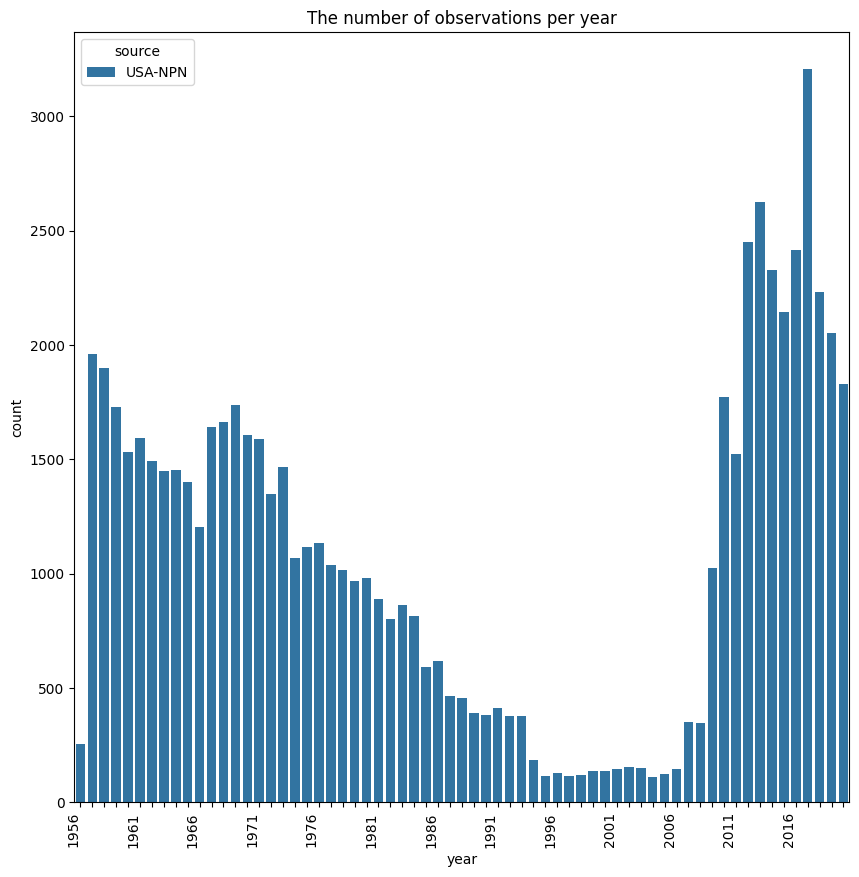

In [12]:
fig, ax= plt.subplots(1,1)  
fig.set_size_inches(10, 10)
plot_ = sns.countplot(x = 'year', hue ='source', data= df)
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.title("The number of observations per year")
plt.show()

#### Spatial Analysis

<Axes: >

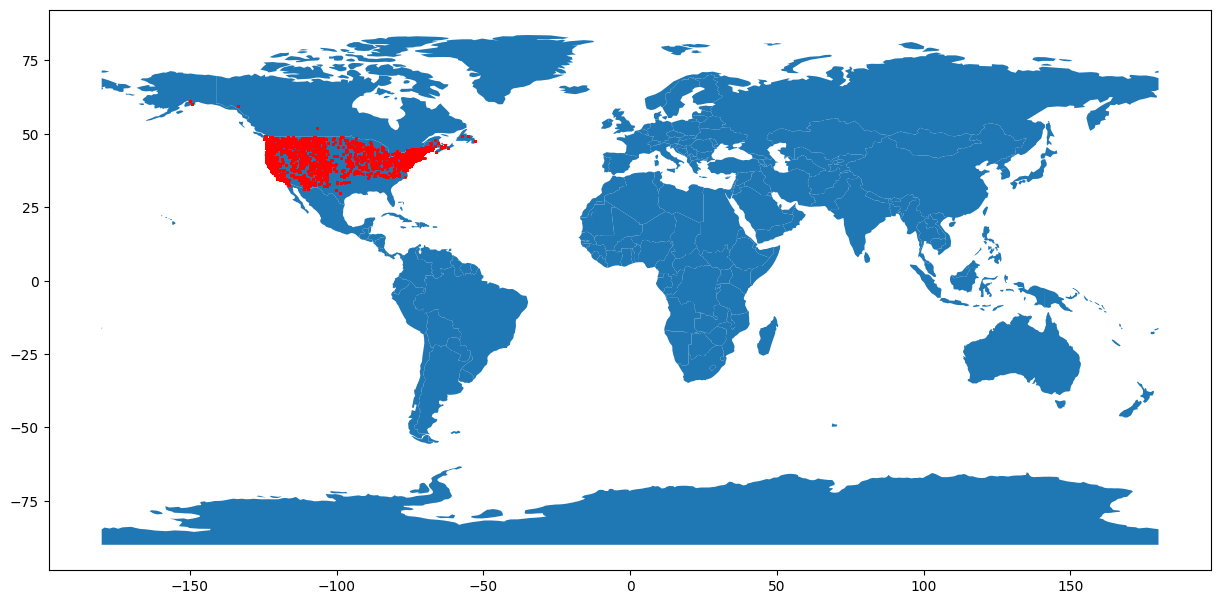

In [13]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df.plot(ax=world.plot(figsize=(15, 15)), marker='.', color='red', markersize=5)

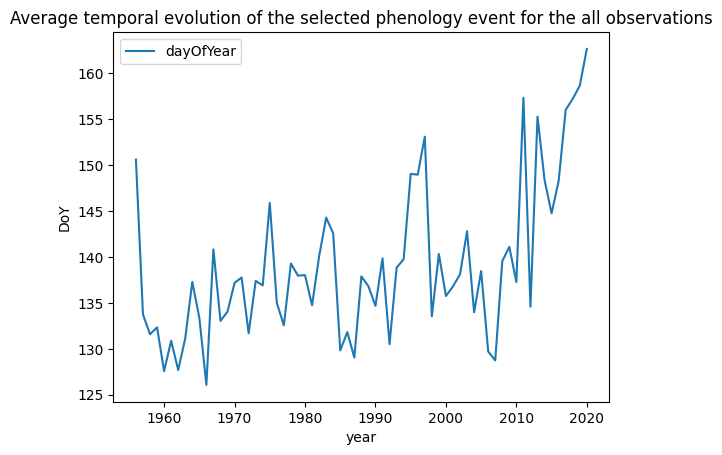

In [14]:
ts1 = df.groupby('year', as_index=False)['dayOfYear'].mean()
ts1.plot(x="year",y="dayOfYear")
plt.title('Average temporal evolution of the selected phenology event for the all observations')
plt.ylabel('DoY')

plt.show()

### Data from a boundingbox

In [26]:
def get_bounding_box(latitude_in_degrees, longitude_in_degrees, half_side_in_km):
    assert half_side_in_km > 0
    assert latitude_in_degrees >= -90.0 and latitude_in_degrees  <= 90.0
    assert longitude_in_degrees >= -180.0 and longitude_in_degrees <= 180.0

    lat = math.radians(latitude_in_degrees)
    lon = math.radians(longitude_in_degrees)

    radius  = 6371
    # Radius of the parallel at given latitude
    parallel_radius = radius*math.cos(lat)

    lat_min = lat - half_side_in_km/radius
    lat_max = lat + half_side_in_km/radius
    lon_min = lon - half_side_in_km/parallel_radius
    lon_max = lon + half_side_in_km/parallel_radius
    rad2deg = math.degrees

    box = (rad2deg(lon_min),rad2deg(lat_min),rad2deg(lon_max),rad2deg(lat_max))

    return (box)

In [30]:
#The latitude of Washington, the USA is 47.751076, and the longitude is -120.740135
# The latitude of New York City, NY, USA is 40.730610, and the longitude is -73.935242.
# The latitude of Tennessee, USA is 35.860119, and the longitude is -86.660156. Tennessee,

target_lat = 47.751076
target_lon = -120.740135


# boundingbox around Washington
half_side_in_km = 50
bbox = get_bounding_box(target_lat,target_lon,half_side_in_km)
bbox

(-121.40892188082722,
 47.30141519704063,
 -120.07134811917277,
 48.20073680295936)

In [17]:
dataset = RPPO(genus="Syringa", termID="obo:PPO_0002032", limit=99000, years=[1950, 2020], area=dict(name="Washington", bbox=bbox))
dataset

RPPO(dataset='rppo', genus='Syringa', termID='obo:PPO_0002032', years=(1950, 2020), area=NamedArea(name='Washington', bbox=(-121.40892188082722, 47.30141519704063, -120.07134811917277, 48.20073680295936)), limit=99000, timeLimit=60)

In [18]:
dataset.download()
df_wa= dataset.load()
df_wa.head()


R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(rppo)
>         response <- ppo_data(genus = c("Syringa"), termID='obo:PPO_0002032',
+             bbox='47.30141519704063,-121.40892188082722,48.20073680295936,-120.07134811917277',
+             fromYear=1950, toYear=2020,
+             limit=99000, timeLimit = 60)


sending request for data ...
https://biscicol.org/api/v3/download/_search?q=+genus:Syringa++AND+++termID:"obo:PPO_0002032"++AND+++year:>=1950++AND+++year:<=2020++AND+++latitude:>=-121.408921880827+AND++latitude:<=47.3014151970406+AND++longitude:>=-121.408921880827+AND++longitude:<=-120.071348119173++AND+++source:USA-NPN&limit=99000


>         saveRDS(response, file="/tmp/data/PPO/Syringa.obo:PPO_0002032.1950-2020.Washington.rds")
>         
> 


,dayOfYear,year,genus,specificEpithet,eventRemarks,termID,source,eventId,geometry
1,135,1968,Syringa,vulgaris,End bloom (historic lilac/eastern honeysuckle),"obo:PPO_0002000,obo:PPO_0002026,obo:PPO_000202...",USA-NPN,urn:phenologicalObservingProcess/2883681,POINT (-121.13000 45.45000)
2,151,1967,Syringa,vulgaris,End bloom (historic lilac/eastern honeysuckle),"obo:PPO_0002000,obo:PPO_0002026,obo:PPO_000202...",USA-NPN,urn:phenologicalObservingProcess/2883677,POINT (-121.13000 45.45000)
3,140,1966,Syringa,vulgaris,End bloom (historic lilac/eastern honeysuckle),"obo:PPO_0002000,obo:PPO_0002032,obo:PPO_000203...",USA-NPN,urn:phenologicalObservingProcess/2883673,POINT (-121.13000 45.45000)
4,149,1963,Syringa,vulgaris,End bloom (historic lilac/eastern honeysuckle),"obo:PPO_0002000,obo:PPO_0002032,obo:PPO_000203...",USA-NPN,urn:phenologicalObservingProcess/2883667,POINT (-121.13000 45.45000)
5,145,1957,Syringa,vulgaris,End bloom (historic lilac/eastern honeysuckle),"obo:PPO_0002000,obo:PPO_0002032,obo:PPO_000203...",USA-NPN,urn:phenologicalObservingProcess/2883649,POINT (-121.13000 45.45000)


In [20]:
print("We have",df_wa.shape[0], "observations")
print("The observations are from",df_wa['year'].min(),"to",df_wa['year'].max())
#df_wa.to_csv("Washington_data.csv")  

We have 2454 observations
The observations are from 1957 to 2020


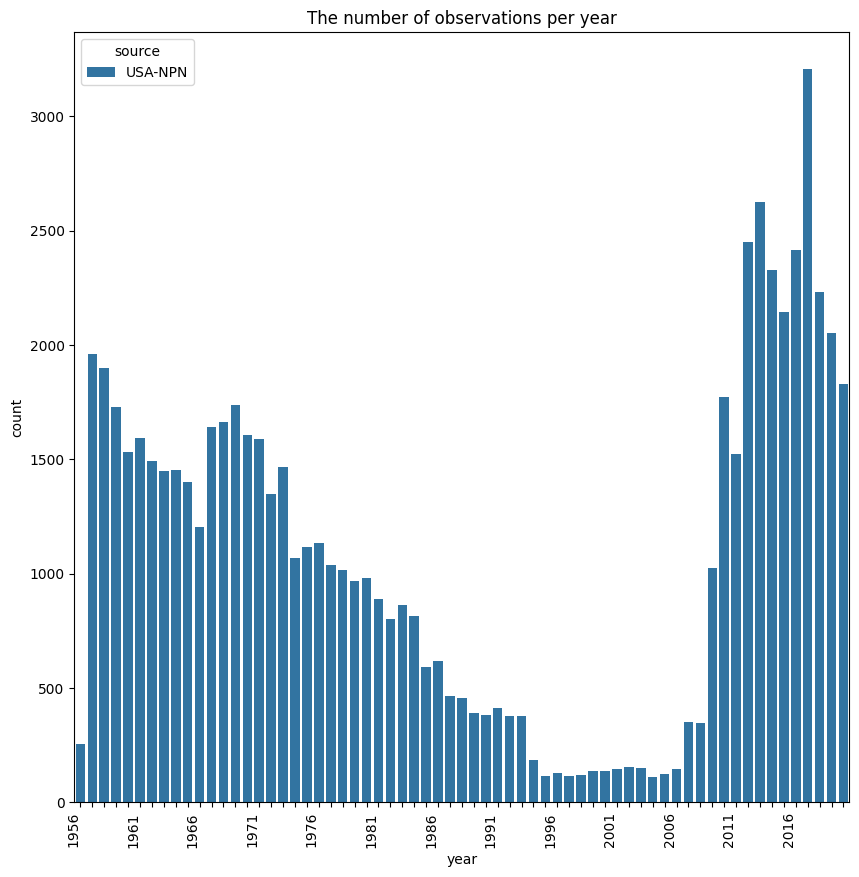

In [23]:
fig, ax= plt.subplots(1,1)  
fig.set_size_inches(10, 10)
plot_ = sns.countplot(x = 'year', hue ='source', data= df)
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.title("The number of observations per year")
plt.show()

#### Spatial Analysis

In [24]:
#create a map
this_map = folium.Map(prefer_canvas=True)

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.geometry.y, point.geometry.x],
                        radius=2,
                        weight=5).add_to(this_map)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
df_wa.apply(plotDot, axis = 1)


#Set the zoom to the maximum possible
this_map.fit_bounds(this_map.get_bounds())

#this_map.save('html_map_output/simple_dot_plot.html')
this_map

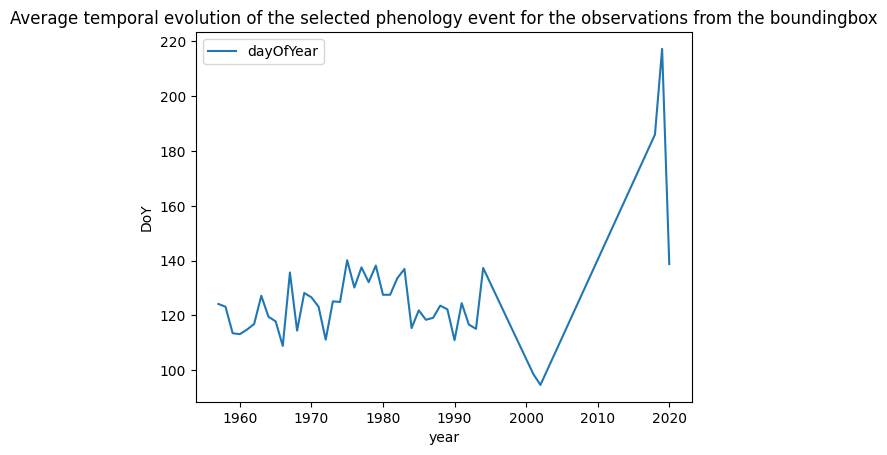

In [32]:
ts2 = df_wa.groupby('year', as_index=False)['dayOfYear'].mean()
ts2.plot(x="year",y="dayOfYear")
plt.title('Average temporal evolution of the selected phenology event for the observations from the boundingbox')
plt.ylabel('DoY')

plt.show()